Author:  Raphael Cousin

Project: https://github.com/racousin/algorithms_basics_python

# Theory

__Context:__

* Data : $X \in \mathbb{R}^d$ 


* Classes : $Y \in \{-1,1\}$

* Classifier :
$g^*(x) = \left\{\begin{array}{ll}1 & if\quad\mathbb{P}(Y = 1 | X = x) >\mathbb{P}(Y = -1 | X = x) \\-1 & else\end{array}\right.$

* sample size: $n$

* feature size : $p$

__Hypothesis:__

$\exists (\alpha, \beta) \in \mathbb{R} \times \mathbb{R}^p$ such as $\forall x \in \mathbb{R}^p:$

$log \left(\frac{\mathbb{P}(Y=1 | X = x)}{\mathbb{P}(Y=-1 | X = x)}\right) = \alpha + \beta^Tx$

__Likelihood-Logistic loss-Mean square error:__

$l:x \in \mathbb{R}^p \mapsto log(1 + e^{-x})$

$L(X,Y,alpha,beta) = \mathbb{P}(X,Y|\alpha, \beta) = \left(l(Y(\alpha + \beta^TX)\right)^{-1}$

$R(f) = \mathbb{E}\left[ log\left(l(Yf(X)\right)\right]$

__Results:__


$g^*(x) = \left\{\begin{array}{ll}1 & if \quad f^*(x)>0\\-1 & else\end{array}\right.$

with:

$f^*(x)=\alpha_0 + \beta_0^Tx \in Argmin_{affine-functions}R(f)$

__Empirical mean square error:__

$\hat{R}(\alpha,\beta) = \frac{1}{n} \sum_{i=1}^{n}log\left( l(Y_i(\alpha+\beta^TXi)\right)$

__Regularization term:__

To ensure a minimum, we pose:

$\tilde{R_{\lambda}}(\alpha,\beta) = \frac{1}{n} \sum_{i=1}^{n}log\left( l(Y_i(\alpha+\beta^TXi)\right) + \frac{\lambda}{2} ||\beta||_2^2$

# Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.discriminant_analysis import LinearClassifierMixin

In [46]:
def gradient_regular(ab, X, Y, C=1):
    print(ab[0])
    print(ab[1:])
    tmp = np.exp(-Y*(ab[0] +X.dot(np.array(ab[1:]))))
    ga = (-Y*tmp/(1+tmp)).mean(axis=0)
    tmp2 = np.empty(X.shape)
    for i in range(X.shape[1]):
        tmp2[:,i] = Y*X[:,i] *(tmp/(1+tmp) + 2* ab[i+1] / C)
    gb = [ga] + list(tmp2.mean(axis=0) + 2 * ab[1:])
    return np.asarray(gb)

In [47]:
def f_regular(ab, X, Y, C=1):
    return(log(1+np.exp(-Y*(ab[0] + X.dot(ab[1:])))) + ab[1:].dot(ab[1:]))

In [52]:
def gradient_descent(X,Y,C=1):
    eps=1e-3
    x0 = np.zeros(X.shape[1] + 1)
    grad = lambda x: gradient_regular(x, X, Y)
    f = lambda x: f_regular(x, X, Y)
    cont = lambda it, v: np.linalg.norm(v)>eps
    p = [x0]
    x = x0
    v = grad(x)
    it = 0
    while cont(it, v):
        s = 1
        v_norm = v.dot(v)
        y = x - s * v
        while f(y) > f(x) - s*v_norm/2:
            s /= 2
            y = x - s * v
        x = y
        p.append(x)
        v = grad(x)
        it += 1
    return x

In [53]:
lr = LR()
lr.fit(X_train, Y_train)

0.0
[0. 0.]


ValueError: operands could not be broadcast together with shapes (1000,) (900,) 

In [31]:
#gradient_descent(x0 = np.asarray([0,0,0]))

In [42]:
class LR(BaseEstimator, LinearClassifierMixin):
    """
        Linear disciminant classifier for two classes (-1,1)
    """
    def __init__(self):
        self.coef = None
        self.intercept = None
        
    def fit(self, X, y, C=1):
        #X data numpy array size (n,p)
        #Y class numpy array size (n,)
        tmp = gradient_descent(X,Y)
        self.coef = tmp[1:3]
        self.intercept = tmp[0] 
        return self

    def decision_function(self, X):
        return (X.dot(self.coef) + self.intercept)

    def predict(self, X):
        return np.sign(-self.decision_function(X))

# Example

In [33]:
#2d plot function
def plot_2dX_Y(X, Y, ax=plt):
    X1 = X[Y == 1]
    X2 = X[Y == -1]
    ax.plot(X1[:, 0], X1[:, 1], ">", label="Class 1")
    ax.plot(X2[:, 0], X2[:, 1], "d", label="Class 2")

In [34]:
# plot border from clf
def plot_border(clf, data=None, num=500, label=None,ax=plt):
    """
        Plot the frontiere f(x)=0 of the classifier clf within the same range as the one
        of the data.
        Input:
            clf: binary classifier with a method decision_function
            data: input data (X)
            num: discretization parameter
    """
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, num), np.linspace(ymin, ymax))
    z = np.fabs(clf.decision_function(np.c_[x.ravel(), y.ravel()])).reshape(x.shape)
    zmin, zmax = z.min(), z.max()
    ind = np.where((z-zmin)/(zmax-zmin) < 0.01)
    ind_sort = np.argsort(y[ind])
    ax.plot(x[ind][ind_sort], y[ind][ind_sort], label=label, linewidth=2)

In [35]:
def get_metrics(clf,X,Y):
    """
        Input:
            clf: binary classifier with a method predict_function
            data: (X)
            classes: (Y) consider that Y=1 is 'yes class' and Y=-1 is 'No class'
    """
    pred = clf.predict(X)
    TP = ((pred == 1) & (Y == 1)).sum()
    TN = ((pred == -1) & (Y == -1)).sum()
    FP = ((pred == 1) & (Y == -1)).sum()
    FN = ((pred == -1) & (Y == 1)).sum()
    accuracy = (TP + TN) / (TP + TN + FN + FP)
    prec = TP/ (TP + FP)
    recall = TP / (TP + FN)
    F1Score = 2*(recall * prec) / (recall + prec)
    print('True Positive:',TP)
    print('True Negative:',TN)
    print('False Positive:',FP)
    print('False Negative:',FN)
    print('Accuracy:', accuracy)
    print('Precision:', prec)
    print('Recall:', recall)
    print('F1 Score:', F1Score)

In [36]:
#generate data
p = 2;
n = 1000;
mu1 = np.random.randn(p) +3
mu2 = np.random.randn(p) -2
A = np.random.rand(p,p)
sigma1 = np.dot(A,A.transpose())
A = np.random.rand(p,p)
sigma2 = np.dot(A,A.transpose())

n1 = np.random.randint(int(n*0.1),int(n*0.9));
n2 = n - n1;
X1 = np.random.multivariate_normal(size=n1,mean=mu1,cov=sigma1)
X2 = np.random.multivariate_normal(size=n2,mean=mu2,cov=sigma2)

Y1 = np.ones(n1)
Y2 = -np.ones(n2)
X = np.r_[X1, X2]
Y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0])]

In [37]:
#train set and test set
data = np.c_[X,Y]
np.random.shuffle(data)
X_train = data[:int(n *0.9),0:p]
Y_train = data[:int(n *0.9),p]
X_test = data[int(n *0.9):,0:p]
Y_test = data[int(n *0.9):,p]

In [38]:
#compute model
lr = LR()
lr.fit(X_train, Y_train)

TypeError: gradient_descent() got an unexpected keyword argument 'x0'

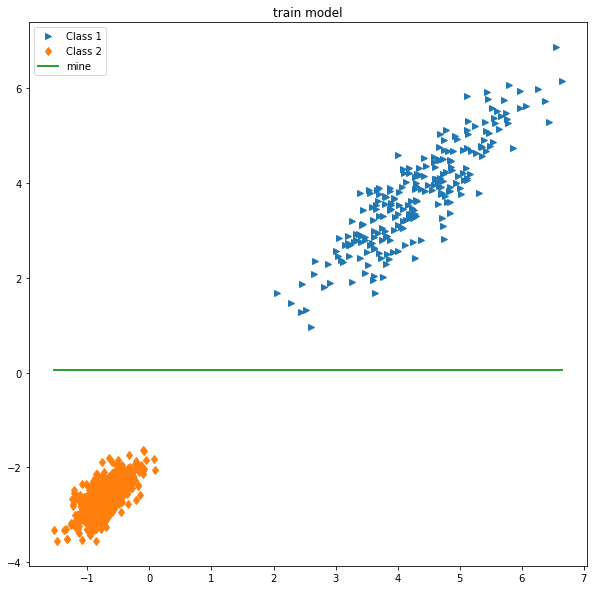

In [12]:
#plot train
fig, ax = plt.subplots(figsize=(10,10))
plot_2dX_Y(X_train, Y_train,ax)
plot_border(lr, X_train,ax = ax,label='mine')
ax.set_title('train model')
ax.legend(loc="best");

In [13]:
#metrics train
get_metrics(lr, X_train, Y_train)

True Positive: 233
True Negative: 667
False Positive: 0
False Negative: 0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


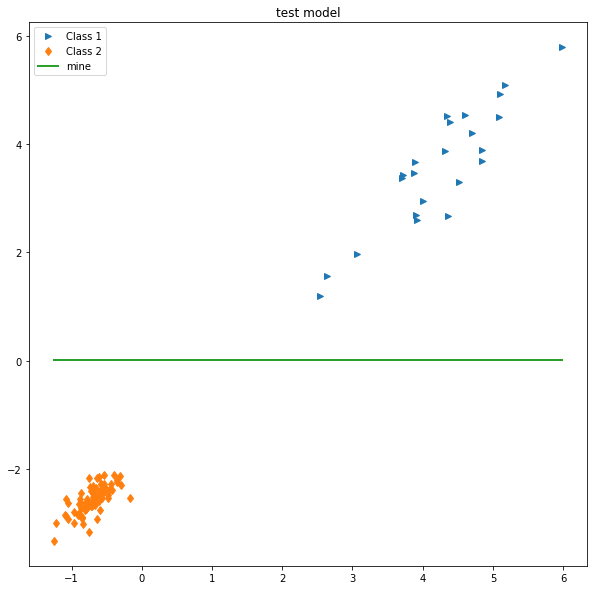

In [14]:
#plot test
fig, ax = plt.subplots(figsize=(10,10))
plot_2dX_Y(X_test, Y_test,ax)
plot_border(lr, X_test,ax = ax,label='mine')
ax.set_title('test model')
ax.legend(loc="best");

In [15]:
#metrics test
get_metrics(lr, X_test, Y_test)

True Positive: 23
True Negative: 77
False Positive: 0
False Negative: 0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


# References

In [16]:
from sklearn.linear_model import LogisticRegression